In [1]:
import SimpleITK as sitk
import tifffile
import skimage
#%matplotlib notebook
import gui
import registration_gui as rgui
import matplotlib.pyplot as plt
import numpy as np
import os
from skimage.segmentation import mark_boundaries
OUTPUT_DIR = "output"

In [114]:
path1 = 'D://Faramarz_data_unsupervised_segmentation//Validation_cube//low_resolution//GMM_3D//Coresponding_img_cross_segmentation_low_res.tif'
#low_res = tifffile.imread(path1)
path2 = 'D://Faramarz_data_unsupervised_segmentation//Validation_cube//high_resolution//GMM_3D//Coresponding_img_cross_segmentation_high_res.tif'
#high_res = tifffile.imread(path2)

path3 = 'D://Faramarz_data_unsupervised_segmentation//Validation_cube//high_resolution//GMM_3D//Mask_corss_segmentation_high_res.tif'
#downsized mask

path4 = 'D://Faramarz_data_unsupervised_segmentation//Validation_cube//high_resolution//GMM_3D//Downsized_Coresponding_img_high_res.tif'
path5 = 'D://Faramarz_data_unsupervised_segmentation//Validation_cube//high_resolution//GMM_3D//Downsized_mask_50%_high_res.tif'
path6 = 'D://Faramarz_data_unsupervised_segmentation//Validation_cube//high_resolution//GMM_3D//Downsized_mask_high_res.tif'

In [115]:
#high_res = tifffile.imread(path2)

In [116]:
#low_res = tifffile.imread(path1)

In [120]:
downsized_tiff = tifffile.imread(path4)
downsized_mask = tifffile.imread(path5)
downsized_mask_not_binary = tifffile.imread(path6)

In [119]:
# use this for downsizing the high-res scans
#scale = 116.44 / 11.77
scale = 10
high_res_mask = tifffile.imread(path3)
downsized_mask = skimage.transform.downscale_local_mean(high_res_mask, scale, cval=0, clip=True)
downsized_mask [ downsized_mask >=0.5] = 1
downsized_mask [ downsized_mask <0.5] = 0
downsized_mask = downsized_mask.astype('uint8')
downsized_mask [downsized_mask]
tifffile.imwrite(path5,downsized_mask)
#plt.imshow(high_res_mask[10],'gray')



In [7]:
#Reading data
fixed_image = sitk.ReadImage(path4, sitk.sitkFloat32)
moving_image = sitk.ReadImage(path1, sitk.sitkFloat32)

In [8]:
initial_transform = sitk.CenteredTransformInitializer(
    fixed_image,
    moving_image,
    sitk.Euler3DTransform(),
    sitk.CenteredTransformInitializerFilter.GEOMETRY,
)

'''
gui.MultiImageDisplay(
    image_list=[fixed_image, moving_image],
    title_list=["fixed", "moving"],
    figure_size=(8, 4),
);'''

'\ngui.MultiImageDisplay(\n    image_list=[fixed_image, moving_image],\n    title_list=["fixed", "moving"],\n    figure_size=(8, 4),\n);'

<IPython.core.display.Javascript object>


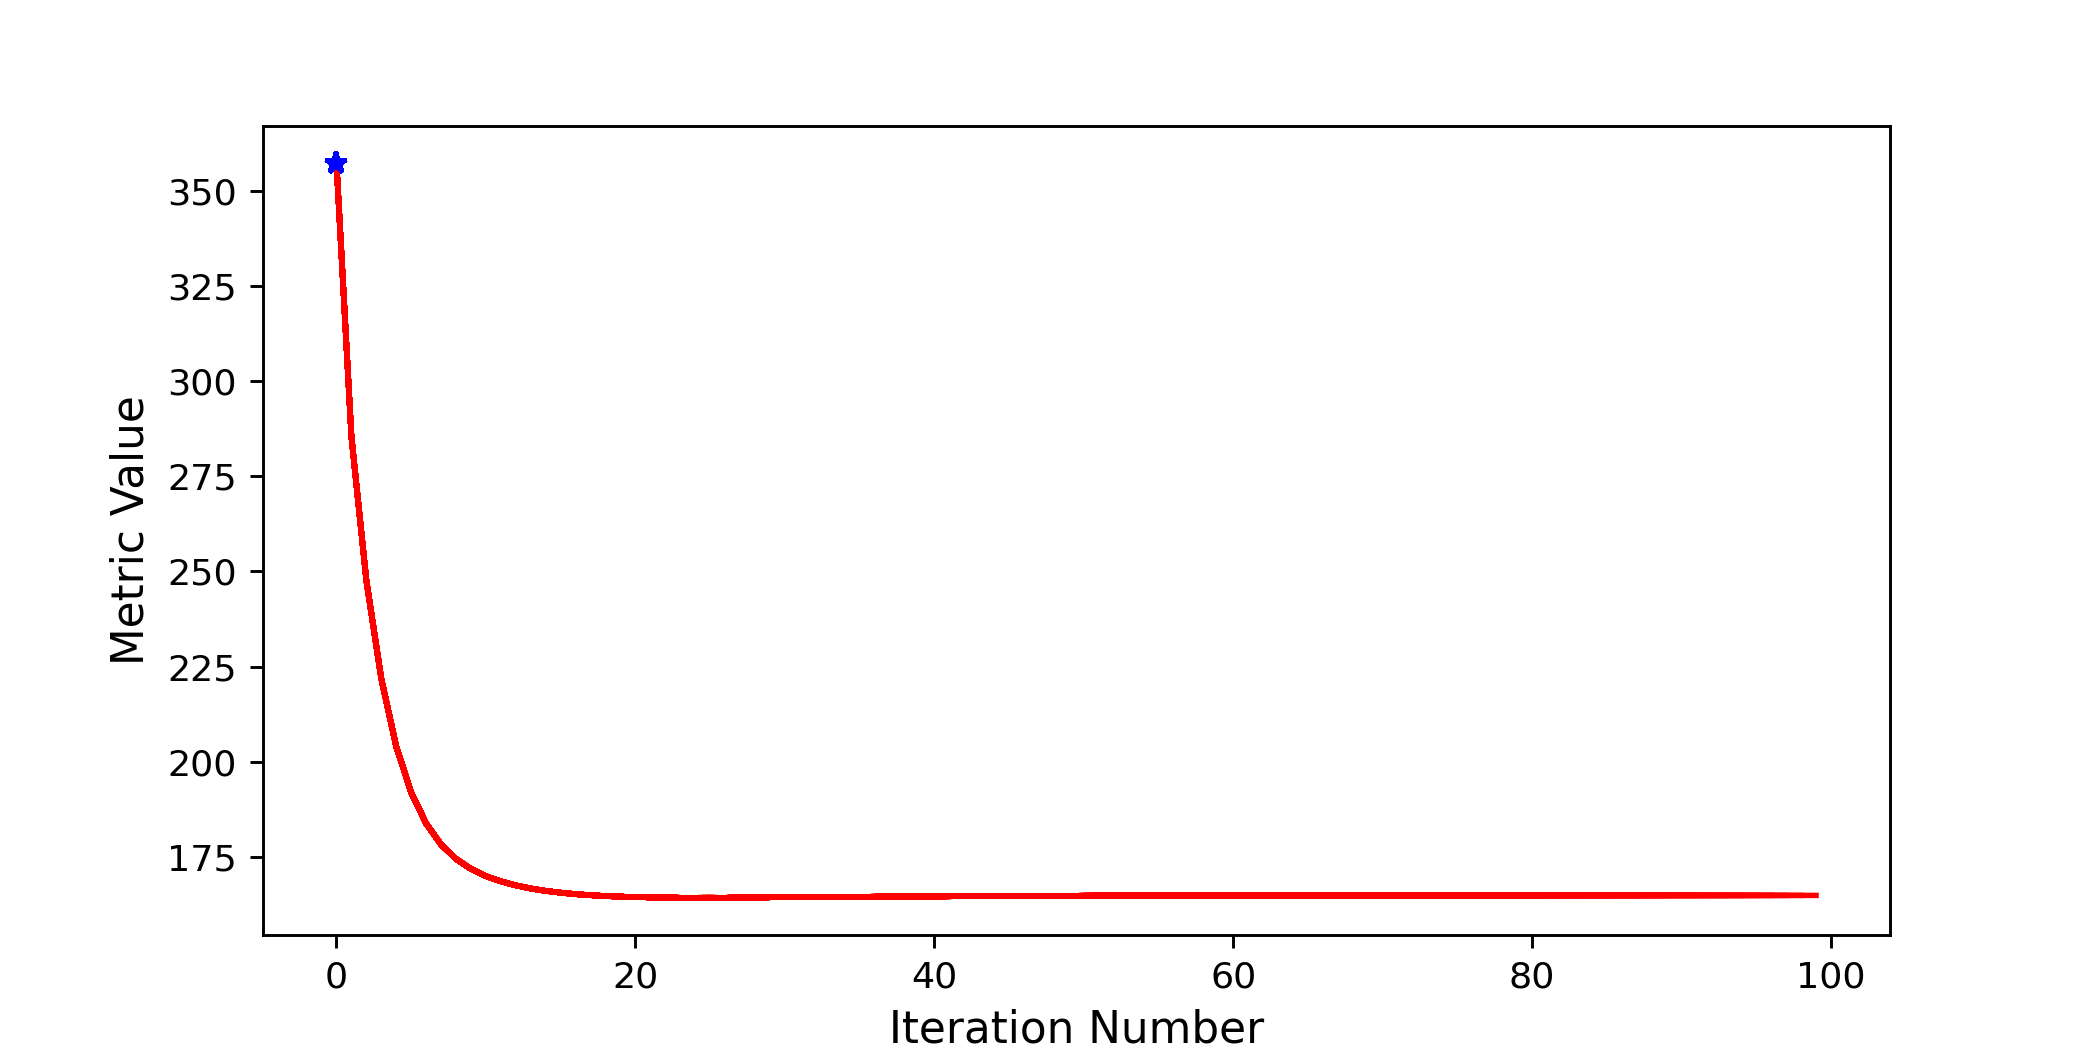

Final metric value: 164.8800236590713
Optimizer's stopping condition, GradientDescentOptimizerv4Template: Maximum number of iterations (100) exceeded.


In [9]:
registration_method = sitk.ImageRegistrationMethod()

# Similarity metric settings.
#registration_method.SetMetricAsMattesMutualInformation(numberOfHistogramBins=1000)
registration_method.SetMetricAsMeanSquares()
registration_method.SetMetricSamplingStrategy(registration_method.RANDOM)
registration_method.SetMetricSamplingPercentage(0.9)

registration_method.SetInterpolator(sitk.sitkLinear)

# Optimizer settings.
registration_method.SetOptimizerAsGradientDescent(
    learningRate=1,
    numberOfIterations=100,
    convergenceMinimumValue=1e-6,
    convergenceWindowSize=100,
)
registration_method.SetOptimizerScalesFromPhysicalShift()

# Setup for the multi-resolution framework.
#registration_method.SetShrinkFactorsPerLevel(shrinkFactors = [4,2,1])
#registration_method.SetSmoothingSigmasPerLevel(smoothingSigmas=[2,1,0])
#registration_method.SmoothingSigmasAreSpecifiedInPhysicalUnitsOn()

# Don't optimize in-place, we would possibly like to run this cell multiple times.
registration_method.SetInitialTransform(initial_transform, inPlace=False)

# Connect all of the observers so that we can perform plotting during registration.
registration_method.AddCommand(sitk.sitkStartEvent, rgui.start_plot)
registration_method.AddCommand(sitk.sitkEndEvent, rgui.end_plot)
registration_method.AddCommand(
    sitk.sitkMultiResolutionIterationEvent, rgui.update_multires_iterations
)
registration_method.AddCommand(
    sitk.sitkIterationEvent, lambda: rgui.plot_values(registration_method)
)

final_transform = registration_method.Execute(fixed_image, moving_image)

# Always check the reason optimization terminated.
print("Final metric value: {0}".format(registration_method.GetMetricValue()))
print(
    "Optimizer's stopping condition, {0}".format(
        registration_method.GetOptimizerStopConditionDescription()
    )
)

<IPython.core.display.Javascript object>


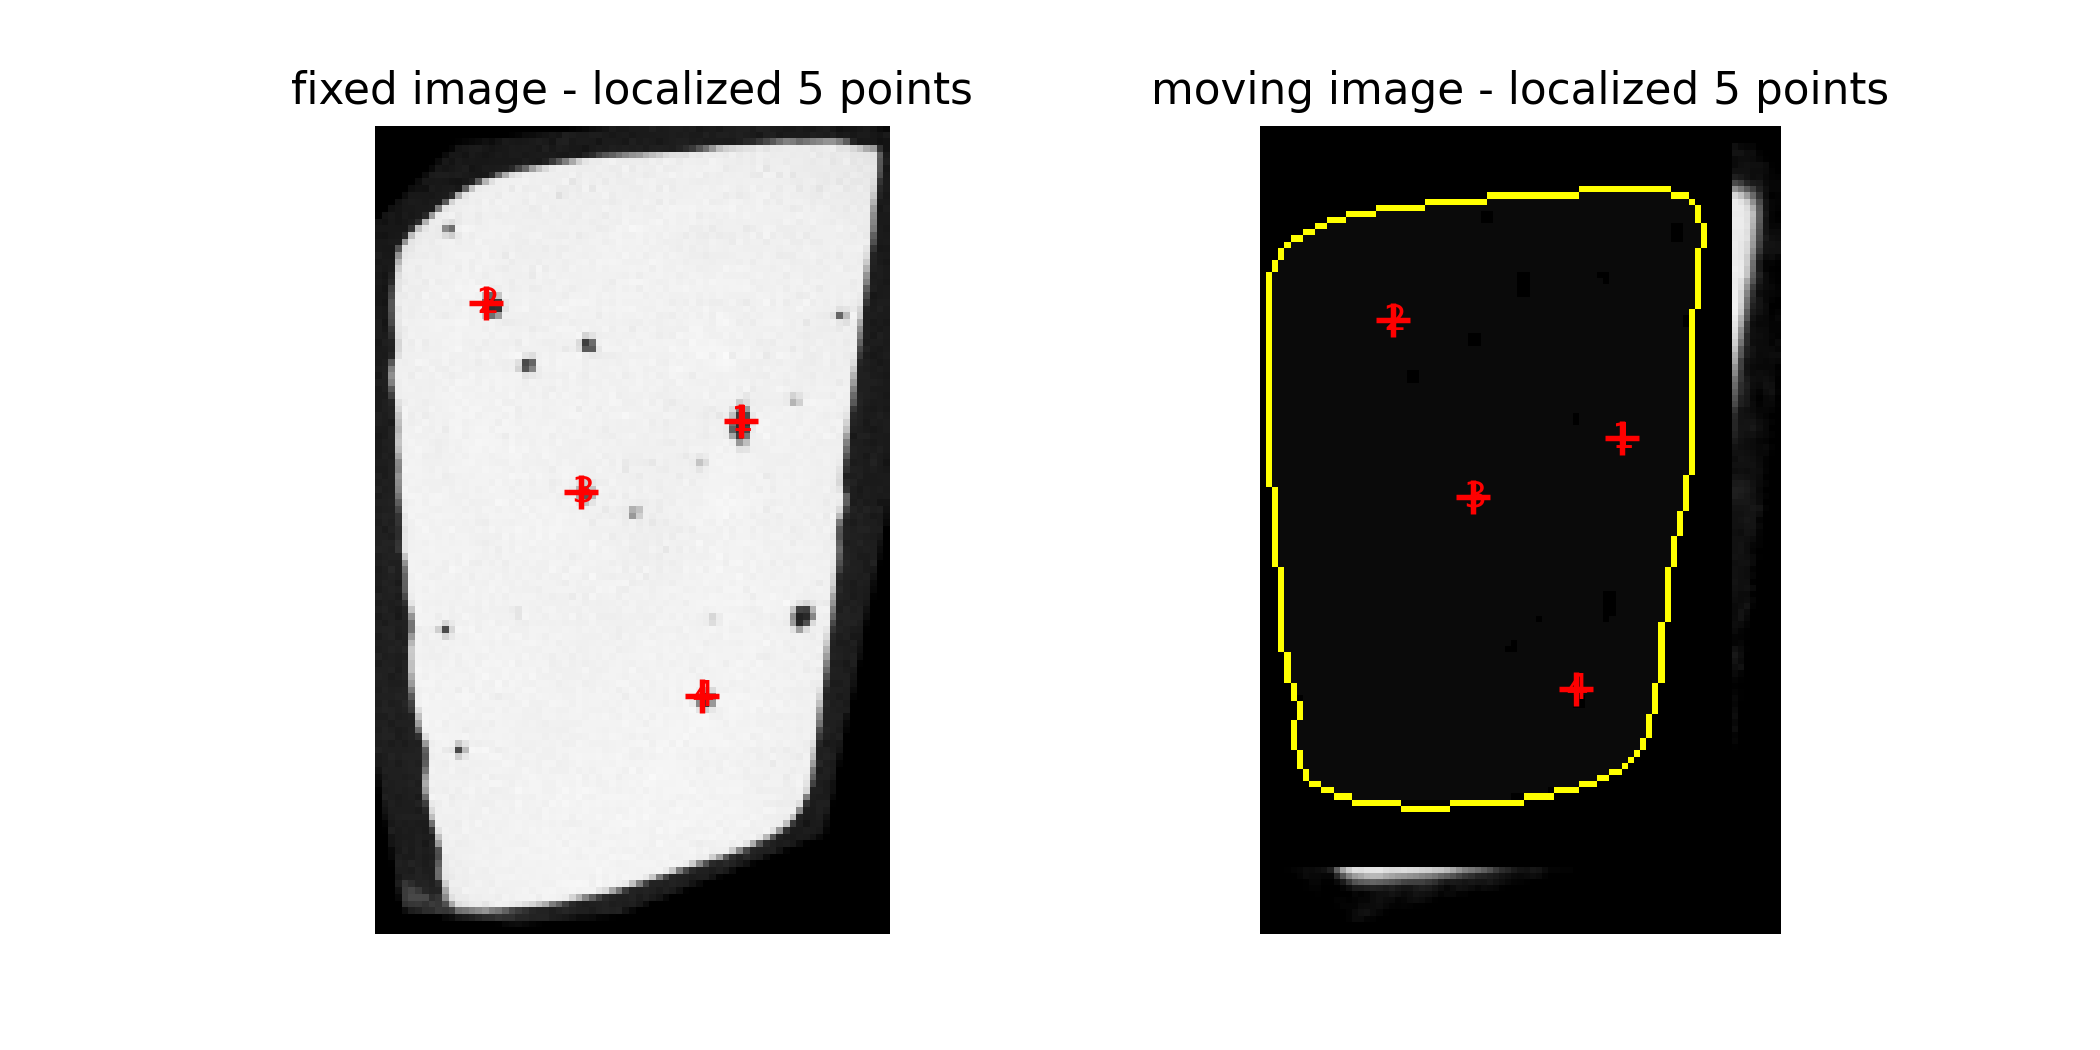

In [10]:
gui.RegistrationPointDataAquisition(
    fixed_image,
    moving_image,
    figure_size=(8, 4),
    known_transformation=final_transform,

);

# Saving the output image

In [11]:
moving_resampled = sitk.Resample(
    moving_image,
    fixed_image,
    final_transform,
    sitk.sitkLinear,
    0.0,
    moving_image.GetPixelID(),
)
sitk.WriteImage(
    moving_resampled, os.path.join(OUTPUT_DIR, "RIRE_training_001_mr_T1_resampled.tif")
)
sitk.WriteTransform(
    final_transform, os.path.join(OUTPUT_DIR, "RIRE_training_001_CT_2_mr_T1.tfm")
)

# checking the output image

In [22]:
output = tifffile.imread('output//RIRE_training_001_mr_T1_resampled.tif')

In [23]:
print ('registered image shape = ', output.shape)
print ('target image shape = ', downsized_tiff.shape)

registered image shape =  (67, 121, 77)
target image shape =  (67, 121, 77)


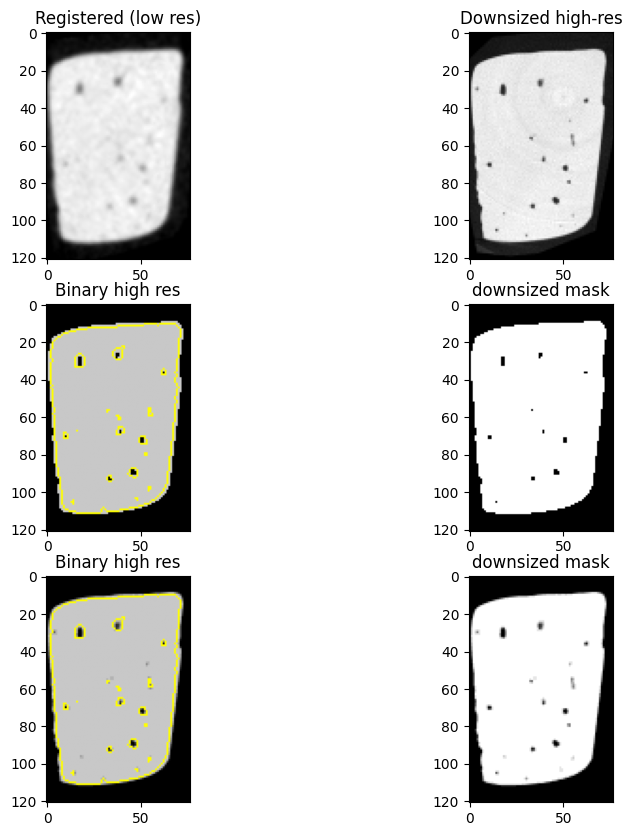

In [140]:
n = 10
fig, ((ax1, ax2),(ax3,ax4),(ax5,ax6)) = plt.subplots(3, 2,figsize=(10, 10))

ax1.imshow(output[n],'gray')
ax1.set_title('Registered (low res)')
#target is 3 images ahead of the registered image 
ax2.imshow(downsized_tiff[n],'gray')
ax2.set_title('Downsized high-res')

# Thresholding 
# to get the borders and check the registration
thresh =138
output_seg = np.zeros_like(output).astype('uint8')
output_seg[output > thresh] = 1

ax3.imshow(mark_boundaries(downsized_mask[n]*200, output_seg[n] ))
ax3.set_title('Binary high res')

ax4.imshow(downsized_mask[n]*200,'gray')
ax4.set_title('downsized mask')



ax5.imshow(mark_boundaries(downsized_mask_not_binary[n]*20, output_seg[n] ))
ax5.set_title('Binary high res')

ax6.imshow(downsized_mask_not_binary[n]*10,'gray')
ax6.set_title('downsized mask')



plt.savefig('fig.png', dpi = 400)